# Logistic Regression Modeling of Colorectal Cancer Risk using PLCO Study Data


In [4]:
# load packages
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import tensorflow as tf


### Read in data

In [5]:
file_path = os.path.join(os.getcwd(), 'merged_dataset.csv')
df = pd.read_csv(file_path)
print(df.shape)

(96561, 322)


### Data Cleaning

In [6]:
#columns are removed for the following reasons: 
#1. Functionally identifies Colon Cancer Status 
#2. Identifer such as study Id 
#3. Study metadata that is not practical for a working model. 
#4. Known correlation with other columns (see comments)
#5. Unexplainable missing data (see comments)

print("Starting DataFrame Shape")
print(df.shape)

cols_to_remove = [
    #1
    'colo_appendix_cancer',
    'colo_exitage',
    'colo_exitdays',
    'colo_exitstat',
    'colo_icdO2_tmrloc',
    'colo_mra_stat0',
    'd_dthc',
    'f_dthc',
    'fstcan_exitage',
    'fstcan_exitdays',
    'fstcan_exitstat',
    'iaden_exclusion',
    'intstatc_cat',
    'is_dead',
    'is_dead_with_cod',
    'mortality_exitage',
    'mortality_exitdays',
    'mortality_exitstat',
    'num_cancc',
    'ph_colo_trial',
    'ph_colo_bq',
    'primary_trtc',
    'reconsent_outcome',
    'reconsent_outcome_days',
    #2
    'plco_id',
    'AddrID',
    'addr_enrollment',
    #3
    'bq_compdays',
    'bq_returned',
    'center',
    'colo_eligible_bq',
    'colo_eligible_dhq',
    'colo_eligible_sqx',
    'entryage_bq',
    'entrydays_bq',
    'in_TGWAS_population',
    'rndyear',
    #4
    'bq_age', #same as age, 
    'agelevel', #redundant with age,
    #5
    'census_pct_white_2000', #most of them are zero while 1990 and 2010 are not. 
    'bmi_20', # dependent on age and weight. 
    'bmi_50', # dependent on age and weight. 
    'weight20_f', # dependent on age and weight. 
    'weight50_f' # dependent on age and weight. 
]

#remove any participants that had a previous history with colon cancer
df= df[df['ph_colo_bq']!=1]  

df = df.drop(columns=cols_to_remove)

print("Updated DataFrame Shape")
print(df.shape)

Starting DataFrame Shape
(96561, 322)
Updated DataFrame Shape
(96535, 278)


### Feature Generation

In [7]:
# ADI, Yost Score, ADI Rank, and %White are averaged across multiple years from 1990 to 2020. 
# Each measure correlates strongly with other years. 
# %White 2000 was removed because it had unexplainably more missing data than other years. 

census_yostscore_columns = [col for col in df.columns if 'census_yostscore' in col]
census_adi_natrank_columns = [col for col in df.columns if 'census_adi_natrank' in col]
census_adi_staterank_columns = [col for col in df.columns if 'census_adi_staterank' in col]
census_pct_white_columns = [col for col in df.columns if 'census_pct_white' in col]

df['census_yostscore_avg'] = df[census_yostscore_columns].mean(axis=1)
df['census_adi_natrank_avg'] = df[census_adi_natrank_columns].mean(axis=1)
df['census_adi_staterank_avg'] = df[census_adi_staterank_columns].mean(axis=1)
df['census_pct_white_avg'] = df[['census_pct_white_1990', 'census_pct_white_2010']].mean(axis=1)

#Create majority/minority race grouping with 1 being majority (white)
df['race1'] = (df['race7'] == 1).astype(int)

df.drop(columns=census_yostscore_columns+census_adi_natrank_columns+census_adi_staterank_columns+census_pct_white_columns, inplace=True)

#fill missing values with Median
df = df.apply(lambda x: x.fillna(x.median()), axis=0)


### Feaure Selection

In [8]:
#segment the data into different categories for model building and feature selection

df_census = df.filter(like='census', axis=1)
census_cols = df_census.columns.tolist()

address_cols = [
    'addr_duration_days',
    'addr_total'
]

health_and_demographics_cols = [
    'asppd',
    'cigpd_f',
    'cig_years',
    'pack_years',
    'height_f',
    'ibuppd',
    'weight_f',
    'brothers',
    'educat',
    'race1',
    'age',
    'bmi_curr'
]


In [ ]:
# Recursive Feature Extraction using Logistic Regression, base Random Forest with Sampling techniques: SMOTE, ADASYN, RandomUnderSampling
# Feature selection is run on Census and Health feature sets seperately.
# The results are saved into a CSV for further inspection. 

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

X = df[census_cols]
y = df['colo_cancer']

# make sure this test train split is the same as the one used in the model building. i.e. set random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=50),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', random_state=42)
}

sampling_techniques = {
    'RandomUnderSampling': RandomUnderSampler(sampling_strategy=1, random_state=42),
    'SMOTE-all': SMOTE(sampling_strategy='all', random_state=42),
    'SMOTE-minority': SMOTE(sampling_strategy='minority', random_state=42),
    'ADASYN-all': ADASYN(sampling_strategy='all', random_state=42),
    'ADASYN-minority': ADASYN(sampling_strategy='minority', random_state=42)
}

results = pd.DataFrame()

for model_name, model in models.items():
    for sampling_name, sampler in sampling_techniques.items():
        print(f"Running RFECV with {model_name} and {sampling_name}...")

        # Resample the data
        X_resampled, y_resampled = sampler.fit_resample(X, y)

        if model_name == 'LogisticRegression':
            scaler = StandardScaler()
            X_resampled = scaler.fit_transform(X_resampled)

        rfecv = RFECV(
            estimator=model,
            step=10,  # Number of features to remove at each iteration
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Stratified K-Fold CV
            scoring='roc_auc',  # Metric to evaluate feature subsets
            n_jobs=-1  # Use all available cores
        )

        rfecv.fit(X_resampled, y_resampled)

        selected_features = X.columns[rfecv.support_]
        feature_rankings = rfecv.ranking_

        method_results = pd.DataFrame({
            'Feature': X.columns,
            'Ranking': feature_rankings,
            'Selected': rfecv.support_,
            'Model': model_name,
            'Sampling': sampling_name
        })

        results = pd.concat([results, method_results], ignore_index=True)

# Print the results
print("Feature Selection Results:")
print(results)

# Save the results to a CSV file for further analysis
results.to_csv('feature_selection_results.csv', index=False)

In [ ]:
# Step Forward feature selection using Health and demographics features

from sklearn.feature_selection import SequentialFeatureSelector

# change to census_cols to run on census features
X = df[health_and_demographics_cols]
y = df['colo_cancer']

# make sure this test train split is the same as the one used in the model building. i.e. set random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2')
}

sampling_techniques = {
     'RandomUnderSampling': RandomUnderSampler(sampling_strategy=1),
     'SMOTE-minority': SMOTE(sampling_strategy='minority'),
     'ADASYN-minority': ADASYN(sampling_strategy='minority')
}

results = pd.DataFrame()

for model_name, model in models.items():
    for sampling_name, sampler in sampling_techniques.items():
        print(f"Running Sequential Feature Selector with {model_name} and {sampling_name}...")
        X_resampled, y_resampled = sampler.fit_resample(X, y)

        if model_name == 'LogisticRegression':
            scaler = StandardScaler()
            X_resampled = scaler.fit_transform(X_resampled)

        sfs = SequentialFeatureSelector(
            estimator=model,
            n_features_to_select='auto',  #let the selector decide. we will compare results after. 
            direction='forward', 
            scoring='roc_auc', 
            #the data is imbalanced and the model is sensitive to this so we use stratified kfold CV
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
            n_jobs=-1  # more power
        )

        sfs.fit(X_resampled, y_resampled)

        selected_features = X.columns[sfs.get_support()]
        feature_support = sfs.get_support()
        feature_ranking = [1 if support else 0 for support in feature_support]  # 1 for selected, 0 otherwise

        method_results = pd.DataFrame({
            'Feature': X.columns,
            'Ranking': feature_ranking,
            'Selected': feature_support,
            'Model': model_name,
            'Sampling': sampling_name
        })

        results = pd.concat([results, method_results], ignore_index=True)

#export as CSV
results.to_csv('feature_selection_results_sfs.csv', index=False)

In [9]:
#Read in feature selection results

health_recursive_results = pd.read_csv('feature_selection_results.csv')
census_rescursive_results = pd.read_csv('feature_selection_results2.csv')
health_forward_results = pd.read_csv('feature_selection_results_sfs.csv')

# Create Feature sets

health_feature_set1 = health_recursive_results[(health_recursive_results['Model']=='LogisticRegression') & (health_recursive_results['Sampling']=='RandomUnderSampling') & (health_recursive_results['Selected']==True)]['Feature'].tolist()
health_feature_set2 = health_recursive_results[(health_recursive_results['Model']=='RandomForest') & (health_recursive_results['Sampling']=='RandomUnderSampling') & (health_recursive_results['Selected']==True)]['Feature'].tolist()
health_feature_set3 = health_recursive_results[(health_recursive_results['Model']=='LogisticRegression') & (health_recursive_results['Sampling']=='SMOTE-minority') & (health_recursive_results['Selected']==True)]['Feature'].tolist()
health_feature_set4 = health_forward_results[(health_forward_results['Model']=='RandomForest') & (health_forward_results['Sampling']=='ADASYN-minority') & (health_forward_results['Selected']==True)]['Feature'].tolist()
health_feature_set5 = health_forward_results[(health_forward_results['Model']=='LogisticRegression') & (health_forward_results['Sampling']=='ADASYN-minority') & (health_forward_results['Selected']==True)]['Feature'].tolist()
health_feature_set6 = [col for col in health_and_demographics_cols if col not in ['bmi_curr', 'cig_years', 'pack_years']] #final feature set for risk calculator
health_feature_set7 = [col for col in health_and_demographics_cols if col not in ['bmi_curr', 'cig_years', 'pack_years', 'age']] #remove age

health_feature_setAll = health_and_demographics_cols

census_feature_set1 = census_rescursive_results[(census_rescursive_results['Model']=='RandomForest') & (census_rescursive_results['Sampling']=='SMOTE-minority') & (census_rescursive_results['Selected']==True)]['Feature'].tolist()

#use VIF to futher filter the Census features
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data 

vif_df = df[census_feature_set1]
vif_df_output = calculate_vif(vif_df)
census_feature_set2 = vif_df_output[vif_df_output['VIF'] < 5]['Feature'].tolist()

#manually curated set of features usinf EDA
census_feature_set3 = ['census_yostscore_avg','census_adi_natrank_avg','census_adi_staterank_avg','census_pct_white_avg','census_b19013_001e_acs5', 'census_b19059_001e_acs5','census_below_poverty_acs5', 'census_gini_index_acs5','census_inurban','census_less_than_hs_acs5', 'census_median_hh_inc_2000','census_over_16_unemploy_acs5','census_pct_no_ins_acs5','census_population_acs5']

#selected features with Effect size > 0.10 and pvalue <0.01 using Two sample t test
census_feature_set4 = [
    "cigpd_f",
    "census_yostscore_avg",
    "census_pct_hhinc_lt30k_2000",
    "census_pct_low_social_acs5",
    "census_adi_staterank_avg",
    "weight_f",
    "height_f",
    "age",
    "total_addr",
    "addr_duration_days",
    "educat"
]

census_feature_setALL = census_cols

addr_features = address_cols


### Logistic Regression Model

In [ ]:
#test logistic regression against each feature set and record the results

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd

# Define the feature sets for feature selection stage
feature_sets = {
    'Feature Set 1': health_feature_set1 + addr_features,
    'Feature Set 2': health_feature_set2 + addr_features,
    'Feature Set 3': health_feature_set3 + addr_features,
    'Feature Set 4': health_feature_set4 + addr_features,
    'Feature Set 5': health_feature_set5 + addr_features,
    'Feature Set 6': health_feature_set6 + addr_features, # this one is used in the final model and dashboard
    'Feature Set 7': health_feature_set7 + addr_features,
    'Feature Set All': health_feature_setAll + addr_features,
    'Census Feature Set 1': census_feature_set1 + addr_features,
    'Census Feature Set 2': census_feature_set2 + addr_features,
    'Census Feature Set 3': census_feature_set3 + addr_features,
    'Census Feature Set 4': census_feature_set4 + addr_features,
    'Address Features Only': addr_features,
    'Census + Health Feature Set 1': census_feature_set1 + health_feature_set6 + addr_features,
    'Census + Health Feature Set 2': census_feature_set2 + health_feature_set6 + addr_features,
    'Census + Health Feature Set 3': census_feature_set3 + health_feature_set6 + addr_features,
    'Census + Health Feature Set 4': census_feature_set4 + health_feature_set6 + addr_features,
}

# startified kfold coross validation for class imbalance 
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define model
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, penalty='l2', solver='liblinear')

# Loop through each feature set
for feature_set_name, feature_set in feature_sets.items():
    print(f"\nRunning model for {feature_set_name}...\n")
    
    X = df[feature_set]
    y = df['colo_cancer']
    
    # Find the average best threshold from ROC
    best_thresholds = []
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Encode the target variable
        labelencoder = LabelEncoder()
        y_train = labelencoder.fit_transform(y_train)
        y_test = labelencoder.transform(y_test)
        
        model.fit(X_train, y_train)
        
        pred_probs = model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
        best_threshold_index = (tpr - fpr).argmax()
        best_threshold = thresholds[best_threshold_index]
        best_thresholds.append(best_threshold)
    
    average_threshold = np.mean(best_thresholds)
    print(f"Average Best Threshold: {average_threshold:.4f}")
    
    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    auc_scores = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        labelencoder = LabelEncoder()
        y_train = labelencoder.fit_transform(y_train)
        y_test = labelencoder.transform(y_test)
        
        model.fit(X_train, y_train)
        
        pred_probs = model.predict_proba(X_test)[:, 1]
        target_prediction = (pred_probs >= average_threshold).astype(int)
        
        accuracy = accuracy_score(y_test, target_prediction)
        recall = recall_score(y_test, target_prediction)
        precision = precision_score(y_test, target_prediction)
        f1 = f1_score(y_test, target_prediction)
        auc = roc_auc_score(y_test, pred_probs)
        
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        f1_scores.append(f1)
        auc_scores.append(auc)
    
    print("\nCross-Validation Results with Average Threshold:")
    print(f"Accuracy: Mean = {np.mean(accuracy_scores):.4f}, Std = {np.std(accuracy_scores):.4f}")
    print(f"Recall: Mean = {np.mean(recall_scores):.4f}, Std = {np.std(recall_scores):.4f}")
    print(f"Precision: Mean = {np.mean(precision_scores):.4f}, Std = {np.std(precision_scores):.4f}")
    print(f"F1 Score: Mean = {np.mean(f1_scores):.4f}, Std = {np.std(f1_scores):.4f}")
    print(f"AUC Score: Mean = {np.mean(auc_scores):.4f}, Std = {np.std(auc_scores):.4f}")


Running model for Feature Set 1...

Average Best Threshold: 0.4933

Cross-Validation Results with Average Threshold:
Accuracy: Mean = 0.5978, Std = 0.0059
Recall: Mean = 0.6058, Std = 0.0336
Precision: Mean = 0.0241, Std = 0.0012
F1 Score: Mean = 0.0463, Std = 0.0024
AUC Score: Mean = 0.6415, Std = 0.0138

Running model for Feature Set 2...

Average Best Threshold: 0.4946

Cross-Validation Results with Average Threshold:
Accuracy: Mean = 0.6006, Std = 0.0062
Recall: Mean = 0.6071, Std = 0.0316
Precision: Mean = 0.0243, Std = 0.0011
F1 Score: Mean = 0.0467, Std = 0.0021
AUC Score: Mean = 0.6417, Std = 0.0135

Running model for Feature Set 3...

Average Best Threshold: 0.4949

Cross-Validation Results with Average Threshold:
Accuracy: Mean = 0.6015, Std = 0.0063
Recall: Mean = 0.6019, Std = 0.0276
Precision: Mean = 0.0241, Std = 0.0010
F1 Score: Mean = 0.0464, Std = 0.0020
AUC Score: Mean = 0.6416, Std = 0.0134

Running model for Feature Set 4...

Average Best Threshold: 0.5024

Cross-V

In [10]:
# Train the final model using the selected features
# In this case, we will use the health_feature_set6 + addr_features which are selected for the final risk calculator

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

X = df[health_feature_set6 + addr_features] 
y = df['colo_cancer']

# Initialize lists to store metrics for each fold
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
auc_scores = []
confusion_matrices = []  # List to store confusion matrices for each fold

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    labelencoder = LabelEncoder()
    scaler = StandardScaler()
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, penalty='l2', solver='liblinear')
    # Encode and scale the data
    target_train = labelencoder.fit_transform(y_train)
    features_train = scaler.fit_transform(X_train)
    target_test = labelencoder.fit_transform(y_test)
    features_test = scaler.fit_transform(X_test)
    
    # Train the model
    model.fit(features_train, target_train)
    
    # Make predictions
    pred_probs = model.predict_proba(features_test)[:, 1]
    threshold = 0.4918  # Use the average threshold from previous step
    target_prediction = (pred_probs >= threshold).astype(int)
    
    # Evaluate the model
    accuracy = accuracy_score(target_test, target_prediction)
    recall = recall_score(target_test, target_prediction)
    precision = precision_score(target_test, target_prediction)
    f1 = f1_score(target_test, target_prediction)
    auc = roc_auc_score(target_test, pred_probs)
    
    # Store the metrics
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    auc_scores.append(auc)
    
    # Calculate and store the confusion matrix
    conf_matrix = confusion_matrix(target_test, target_prediction)
    confusion_matrices.append(conf_matrix)

# Calculate the average confusion matrix
avg_conf_matrix = np.round(np.mean(confusion_matrices, axis=0)).astype(int)

# Calculate and print the mean and standard deviation of metrics across folds
print("Cross-Validation Results:")
print(f"Accuracy: Mean = {np.mean(accuracy_scores):.4f}, Std = {np.std(accuracy_scores):.4f}")
print(f"Recall: Mean = {np.mean(recall_scores):.4f}, Std = {np.std(recall_scores):.4f}")
print(f"Precision: Mean = {np.mean(precision_scores):.4f}, Std = {np.std(precision_scores):.4f}")
print(f"F1 Score: Mean = {np.mean(f1_scores):.4f}, Std = {np.std(f1_scores):.4f}")
print(f"AUC Score: Mean = {np.mean(auc_scores):.4f}, Std = {np.std(auc_scores):.4f}")

# Print the average confusion matrix
print("\nAverage Confusion Matrix:")
print(avg_conf_matrix)

Cross-Validation Results:
Accuracy: Mean = 0.5920, Std = 0.0020
Recall: Mean = 0.6174, Std = 0.0479
Precision: Mean = 0.0241, Std = 0.0018
F1 Score: Mean = 0.0465, Std = 0.0035
AUC Score: Mean = 0.6409, Std = 0.0195

Average Confusion Matrix:
[[5619 3879]
 [  60   96]]


In [11]:
# Save this as the final model and scaler for the risk dashboard
final_scaler = StandardScaler()
final_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, penalty='l2', solver='liblinear')

final_target = LabelEncoder().fit_transform(y)
final_features = final_scaler.fit_transform(X)

final_model.fit(final_features, final_target)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

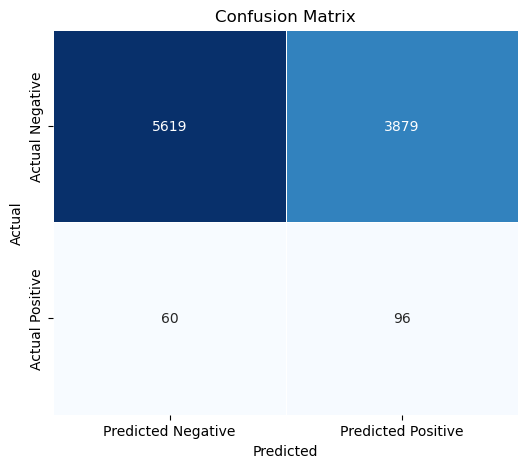

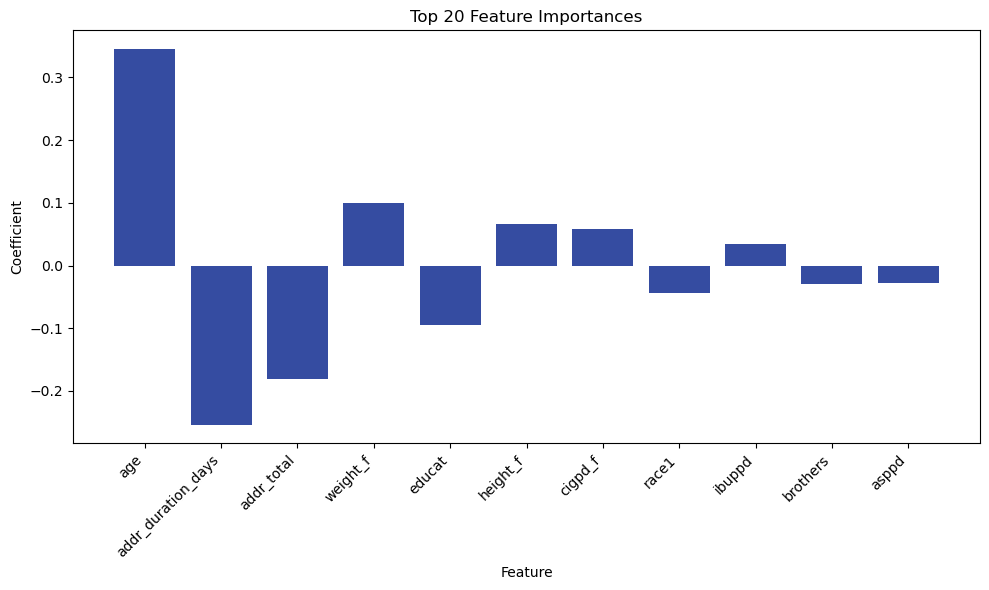

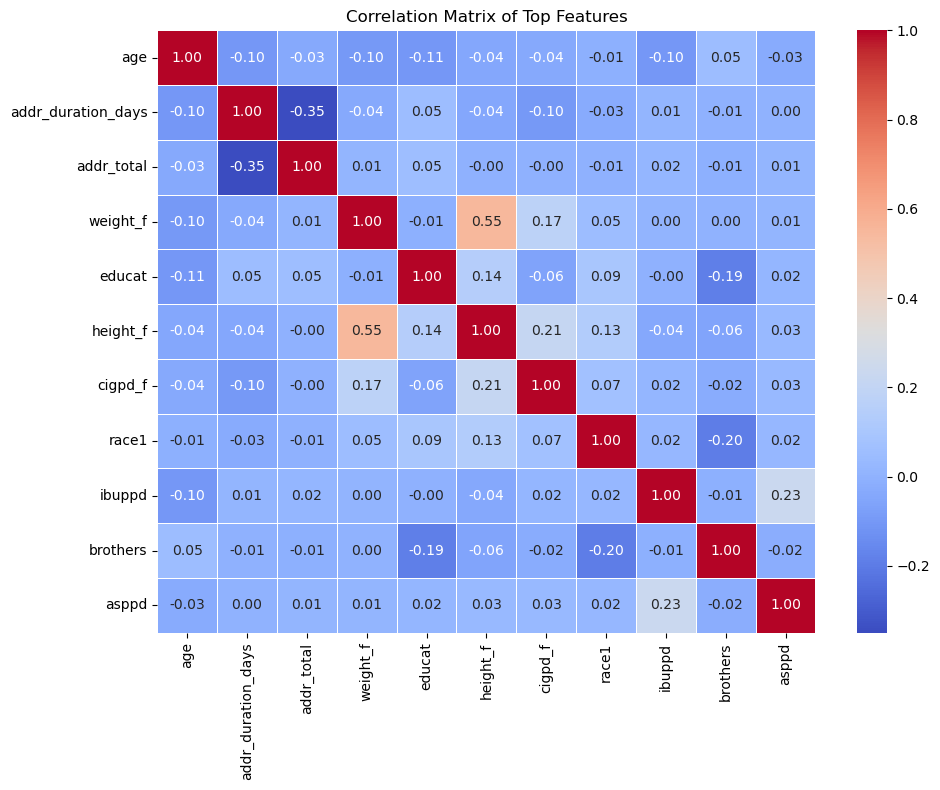

In [ ]:
#for the model above: Confusion matrix, feature importance, correlation plot

# Convert the confusion matrix to a DataFrame for better labeling
confusion_df = pd.DataFrame(
    avg_conf_matrix,
    index=['Actual Negative', 'Actual Positive'],  # Row labels
    columns=['Predicted Negative', 'Predicted Positive']  # Column labels
)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance Plot
coefficients = model.coef_.flatten()
feature_names = X.columns.tolist()
feature_importances = dict(zip(feature_names, coefficients))
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)
top_feature_importances = sorted_feature_importances[:20]

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_importances)), [value for _, value in top_feature_importances], align='center', color='#354CA1')
plt.xticks(range(len(top_feature_importances)), [feature for feature, _ in top_feature_importances], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Correlation Plot for Top Features
top_features = [feature for feature, _ in top_feature_importances]
correlation_matrix = X[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

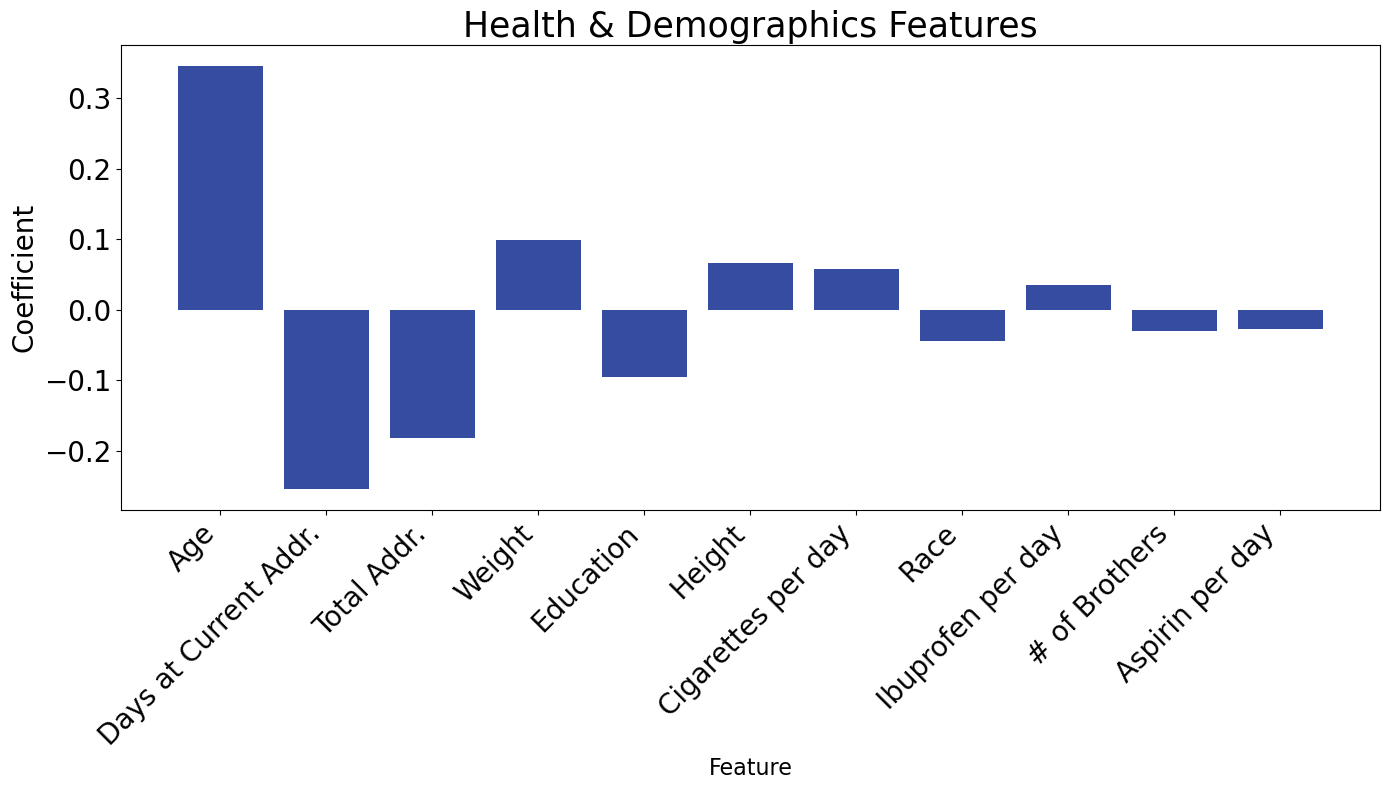

In [14]:
# plots for presentation
coefficients = model.coef_.flatten()
feature_names = X.columns.tolist()

readable_feature_names = {
    'age': 'Age',
    'addr_duration_days': 'Days at Current Addr.',
    'addr_total': 'Total Addr.',
    'weight_f': 'Weight',
    'educat': 'Education',
    'height_f': 'Height',
    'cigpd_f': 'Cigarettes per day',
    'ibuppd': 'Ibuprofen per day',
    'asppd': 'Aspirin per day',
    'race1': 'Race',
    'brothers': '# of Brothers'
}

feature_importances = dict(zip(feature_names, coefficients))

# Sort feature importances by absolute value
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)
top_feature_importances = sorted_feature_importances
top_feature_importances = [(readable_feature_names.get(feature, feature), value) for feature, value in top_feature_importances]


# Plot the feature importances
plt.figure(figsize=(14, 8))  # Increased figure size
plt.bar(range(len(top_feature_importances)), [value for _, value in top_feature_importances], align='center', color='#354CA1')

# Update tick labels and axis labels with larger font sizes
plt.xticks(range(len(top_feature_importances)), [feature for feature, _ in top_feature_importances], rotation=45, ha='right', fontsize=20)  # Increased tick label font size
plt.xlabel('Feature', fontsize=16)  # Increased x-axis label font size
plt.ylabel('Coefficient', fontsize=20)  # Increased y-axis label font size
plt.yticks(fontsize=20)  # Increased y-axis tick label font size
plt.title('Health & Demographics Features', fontsize=25)  # Increased title font size
plt.tight_layout()
plt.show()

# Neural Network

In [ ]:
X = df[health_feature_set6+addr_features]
y = df['colo_cancer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42) 

scaler = StandardScaler()
labelencoder = LabelEncoder()

smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train = labelencoder.fit_transform(y_train)
X_train = scaler.fit_transform(X_train)

y_test = labelencoder.fit_transform(y_test)
X_test = scaler.fit_transform(X_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['auc'])
model.summary()

/Users/michaelolheiser/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

safety = EarlyStopping(monitor = 'val_loss', patience=5)
model.fit(X_train, y_train, epochs=40, batch_size=32, callbacks=[safety], validation_split=0.2)

# Make predictions on the testing set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print performance metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC Score: {auc}")

Epoch 1/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 3s 585us/step - auc: 0.5805 - loss: 0.6553 - val_auc: 0.0000e+00 - val_loss: 0.7655
Epoch 2/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step - auc: 0.7263 - loss: 0.5915 - val_auc: 0.0000e+00 - val_loss: 0.7244
Epoch 3/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step - auc: 0.7547 - loss: 0.5692 - val_auc: 0.0000e+00 - val_loss: 0.7799
Epoch 4/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step - auc: 0.7698 - loss: 0.5588 - val_auc: 0.0000e+00 - val_loss: 0.7097
Epoch 5/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 546us/step - auc: 0.7762 - loss: 0.5525 - val_auc: 0.0000e+00 - val_loss: 0.7337
Epoch 6/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 549us/step - auc: 0.7812 - loss: 0.5475 - val_auc: 0.0000e+00 - val_loss: 0.7474
Epoch 7/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - auc: 0.7829 - loss: 0.5468 - val_auc: 0.0000e+00 - val_loss: 0.6942
Epoch 8/40
3800/3800 ━━━━━━━━━━━━━━━━━━━━ 2s 547us/step - auc: 0.7855 - loss: 0.5448 - val_auc: 0.0000e+00 - val_loss:

## Risk Calculator Dashboard

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Create input widgets
input_label1 = widgets.Label("Enter your age")
input_box1 = widgets.BoundedIntText(min=0, max=125)

input_label2 = widgets.Label("Enter your weight in pounds")
input_box2 = widgets.BoundedIntText(min=60, max=500)

input_label3 = widgets.Label("Enter your height in inches")
input_box3 = widgets.BoundedIntText(min=48, max=96)

input_label4 = widgets.Label("Do you identify as any of the groups listed below?")
input_box4 = widgets.Dropdown(
    options=['White, Non-Hispanic', 
             'Other', 
             'Select'],
    value='Select',
    description='Race:',
)

#1="White, Non-Hispanic"
#2="Other"


input_label5 = widgets.Label("What is the highest grade or level of schooling you completed?")
input_box5 = widgets.Dropdown(
    options=['Less Than 8 Years', 
             '8-11 Years', 
             '12 Years Or Completed High School', 
             'Post High School Training Other Than College', 
             'Some College', 
             'College Graduate', 
             'Postgraduate', 
             'Select'],
    value='Select',
    description='Eduction:',
)

#1="Less Than 8 Years"
#2="8-11 Years"
#3="12 Years Or Completed High School"
#4="Post High School Training Other Than College"
#5="Some College"
#6="College Graduate"
#7="Postgraduate"


input_label7 = widgets.Label("During times when you smoked, how many cigarettes did or do you usually smoke per day? Choose 0 if you never smoked daily")
input_box7 = widgets.Dropdown(
    options=['0', 
             '1-10', 
             '11-20', 
             '21-30', 
             '31-40', 
             '41-60', 
             '61-80',
             '81+',
             'Select'],
    value='Select',
    description='Number of Cigarettes per day:',
)

#0="0"
#1="1-10"
#2="11-20"
#3="21-30"
#4="31-40"
#5="41-60"
#6="61-80"
#7="81+"

input_label99 = widgets.Label("How many full or half brothers do you have?")
input_box99 = widgets.BoundedIntText(min=0, max=10)


input_label8 = widgets.Label("During the last 12 months, how many pills of aspirin or aspirin containing products did you usually take per day, per week or per month?")
input_box8 = widgets.Dropdown(
    options=['None', 
             '1/Day', 
             '2+/Day', 
             '1/Week', 
             '2/Week', 
             '3-4/Week', 
             '<2/Month',
             '2-3/Month',
             'Select'],
    value='Select',
    description='Aspirin usage:',
)

input_label9 = widgets.Label("During the last 12 months, how many pills of ibuprofen-containing products did you usually take per day, per week, or per month?")
input_box9 = widgets.Dropdown(
    options=['None', 
             '1/Day', 
             '2+/Day', 
             '1/Week', 
             '2/Week', 
             '3-4/Week', 
             '<2/Month',
             '2-3/Month',
             'Select'],
    value='Select',
    description='Ibuprofen usage:',
)

# 0="None"
# 1="1/Day"
# 2="2+/Day"
# 3="1/Week"
# 4="2/Week"
# 5="3-4/Week"
# 6="<2/Month"
# 7="2-3/Month"

#The study participants were asked to provide their home address at the time of enrollment and the study lasted for about 10 years. 
input_label10 = widgets.Label("How many home addresses do you currently have or will have in the next 10 years?")
input_box10 = widgets.BoundedIntText(min=0, max=10)

input_label11 = widgets.Label("How many days have you lived under your current addresses?")
input_box11 = widgets.BoundedIntText(min=0, max=20000)

# Create a submit button
submit_button = widgets.Button(
    description='Submit',
    button_style='primary',
)


# asppd                 float64
# cigpd_f               float64
# height_f              float64
# ibuppd                float64
# weight_f              float64
# brothers              float64
# educat                float64
# race1                 int64
# age                     int64
# addr_duration_days      int64
# addr_total              int64



In [16]:

# Calculate the average of each column in X_train
X_train_avg = np.mean(X_train, axis=0)


# Create an output widget to display the prediction
output = widgets.Output()


# Define a function to handle the input and make predictions
def on_submit(button):
    with output:
        output.clear_output()
        try:
            # Get the input values
            
            age = int(input_box1.value if input_box1.value != 0 else X_train_avg)
            
            weight_f = float(input_box2.value if input_box2.value != 0 else X_train_avg)
            
            height_f = float(input_box3.value if input_box3.value != 0 else X_train_avg)
            
            race1 = int(1 if input_box4.value == "White, Non-Hispanic" else 0)
            
            educat = float(1 if input_box4.value == "Less Than 8 Years" \
                else 2 if input_box4.value == "8-11 Years"\
                else 3 if input_box4.value == "12 Years Or Completed High School"\
                else 4 if input_box4.value == "Post High School Training Other Than College"\
                else 5 if input_box4.value == "Some College"\
                else 6 if input_box4.value == "College Graduate"\
                else 7 if input_box4.value == "Postgraduate"\
                else 8)
                    
            cigpd_f = float(0 if input_box7.value == "0" \
                else 1 if input_box7.value == "1-10"\
                else 2 if input_box7.value == "11-20"\
                else 3 if input_box7.value == "21-30"\
                else 4 if input_box7.value == "31-40"\
                else 5 if input_box7.value == "41-60"\
                else 6 if input_box7.value == "61-80"\
                else 7 if input_box7.value == "81+"\
                else 1)
            
            asppd = float(0 if input_box8.value == "None" \
                else 1 if input_box8.value == "1/Day"\
                else 2 if input_box8.value == "2+/Day"\
                else 3 if input_box8.value == "1/Week"\
                else 4 if input_box8.value == "2/Week"\
                else 5 if input_box8.value == "3-4/Week"\
                else 6 if input_box8.value == "<2/Month"\
                else 7 if input_box8.value == "2-3/Month"\
                else 2)     

            ibuppd = float(0 if input_box9.value == "None" \
                else 1 if input_box9.value == "1/Day"\
                else 2 if input_box9.value == "2+/Day"\
                else 3 if input_box9.value == "1/Week"\
                else 4 if input_box9.value == "2/Week"\
                else 5 if input_box9.value == "3-4/Week"\
                else 6 if input_box9.value == "<2/Month"\
                else 7 if input_box9.value == "2-3/Month"\
                else 2)     
            
            addr_total = int(input_box10.value if input_box10.value != 0 else X_train_avg)
            
            addr_duration_days = int(input_box11.value if input_box11.value != 0 else X_train_avg)
                
            brothers = float(input_box99.value if input_box99.value != 0 else X_train_avg)
            
            # Create X_test with the input values and averages for missing values
            X_input_data = {
                'asppd':[asppd],
                'cigpd_f':[cigpd_f],
                'height_f':[height_f],
                'ibuppd':[ibuppd],
                'weight_f': [weight_f],
                'brothers':[brothers],
                'educat':[educat],
                'race1':[race1],
                'age': [age],
                'addr_duration_days':[addr_duration_days],
                'addr_total':[addr_total],
                }
            
            X_input = pd.DataFrame(X_input_data)
            features_test_input = final_scaler.transform(X_input)
            # Make predictions using the model
            pred_probs = final_model.predict_proba(features_test_input)[:, 1]
            threshold = 0.5  # Use the threshold from previous model fitting step
            target_prediction = (pred_probs >= threshold).astype(int)
            
            predict_result = "High" if target_prediction == [1]\
                else "Low"
            
            # Print the predictions
            print(f"Risk of having Colon Cancer: {predict_result}")
        except ValueError:
            print("Invalid input. Please enter valid values.")
            

# when submit hit, calculate
submit_button.on_click(on_submit)

# Display the widgets
display(input_label1, 
        input_box1,
        input_label2, 
        input_box2,
        input_label3, 
        input_box3,
        input_label4, 
        input_box4,
        input_label5, 
        input_box5,
        input_label7, 
        input_box7,
        input_label8, 
        input_box8,
        input_label9, 
        input_box9,
        input_label10, 
        input_box10,
        input_label11, 
        input_box11,
        input_label99, 
        input_box99,
        submit_button,
        output)

Label(value='Enter your age')

BoundedIntText(value=0, max=125)

Label(value='Enter your weight in pounds')

BoundedIntText(value=60, max=500, min=60)

Label(value='Enter your height in inches')

BoundedIntText(value=48, max=96, min=48)

Label(value='Do you identify as any of the groups listed below?')

Dropdown(description='Race:', index=2, options=('White, Non-Hispanic', 'Other', 'Select'), value='Select')

Label(value='What is the highest grade or level of schooling you completed?')

Dropdown(description='Eduction:', index=7, options=('Less Than 8 Years', '8-11 Years', '12 Years Or Completed …

Label(value='During times when you smoked, how many cigarettes did or do you usually smoke per day? Choose 0 i…

Dropdown(description='Number of Cigarettes per day:', index=8, options=('0', '1-10', '11-20', '21-30', '31-40'…

Label(value='During the last 12 months, how many pills of aspirin or aspirin containing products did you usual…

Dropdown(description='Aspirin usage:', index=8, options=('None', '1/Day', '2+/Day', '1/Week', '2/Week', '3-4/W…

Label(value='During the last 12 months, how many pills of ibuprofen-containing products did you usually take p…

Dropdown(description='Ibuprofen usage:', index=8, options=('None', '1/Day', '2+/Day', '1/Week', '2/Week', '3-4…

Label(value='How many home addresses do you currently have or will have in the next 10 years?')

BoundedIntText(value=0, max=10)

Label(value='How many days have you lived under your current addresses?')

BoundedIntText(value=0, max=20000)

Label(value='How many full or half brothers do you have?')

BoundedIntText(value=0, max=10)

Button(button_style='primary', description='Submit', style=ButtonStyle())

Output()